In [7]:
import os
import pathlib
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)
        
fetch_housing_data()

In [8]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    return pd.read_csv(os.path.join(housing_path, 'housing.csv'))

In [9]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


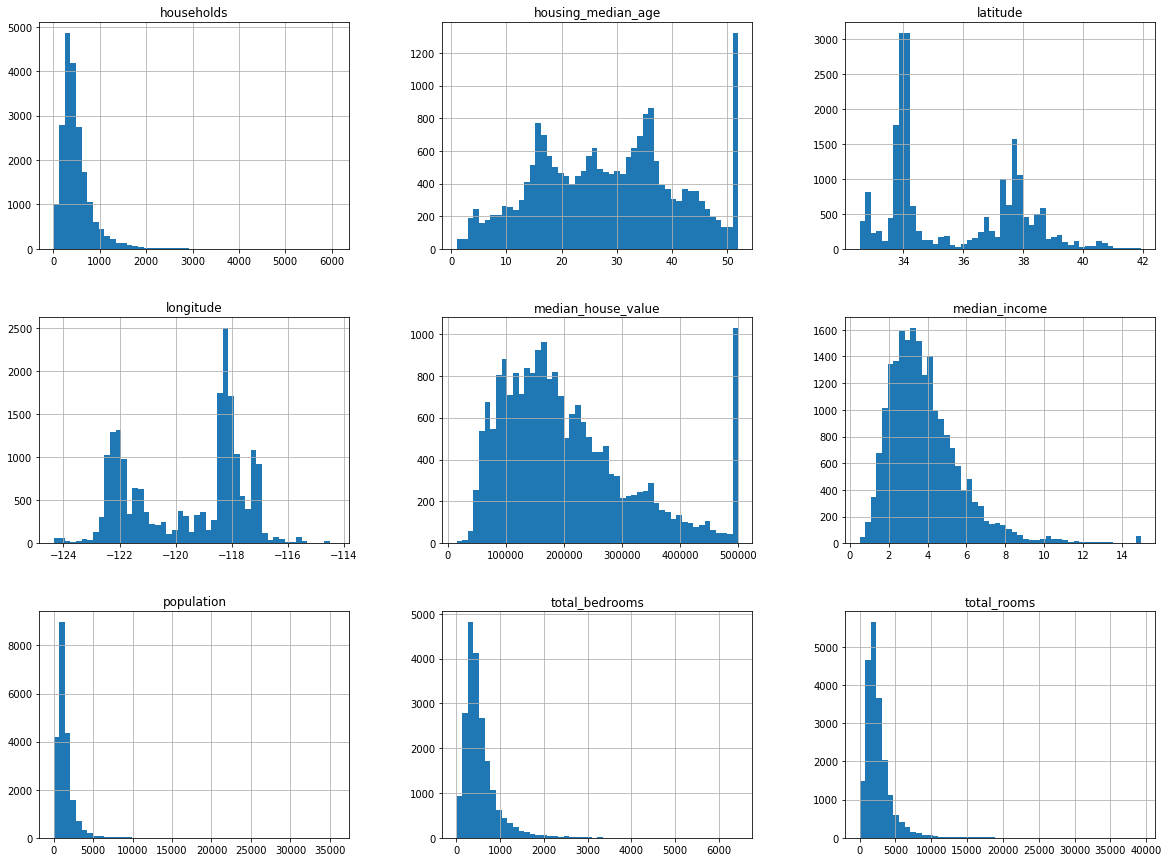

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [19]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), 'train + ', len(test_set), 'test')

16512 train +  4128 test


In [24]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [25]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [26]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [27]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [34]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

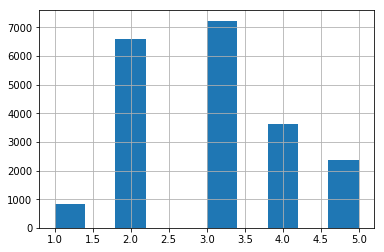

In [38]:
housing['income_cat'].hist()

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [43]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [44]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [45]:
housing = strat_train_set.copy()

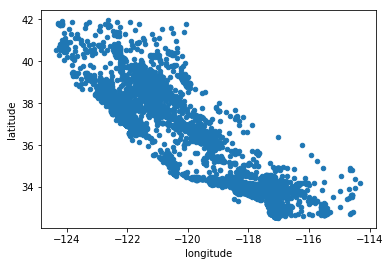

In [46]:
housing.plot(kind='scatter', x='longitude', y='latitude')

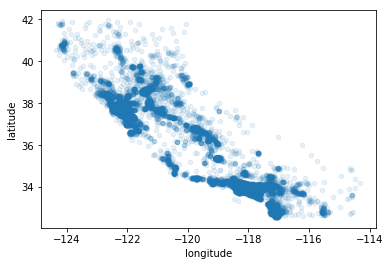

In [47]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

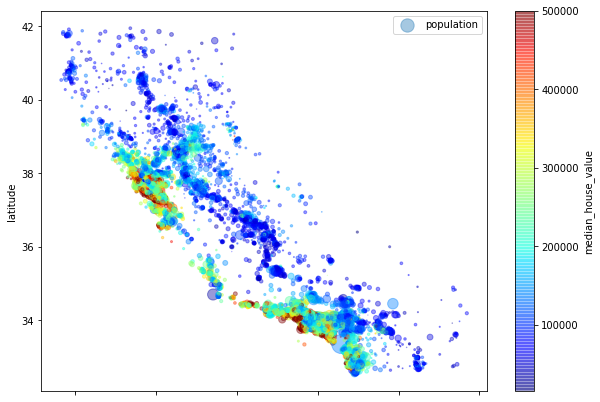

In [49]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10, 7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [50]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3e44d2390>,
      dtype=object)

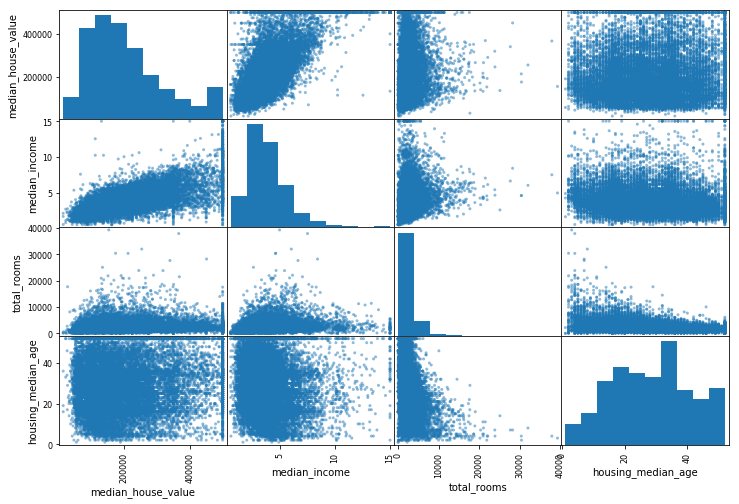

In [53]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3df25fc18>,
      dtype=object)

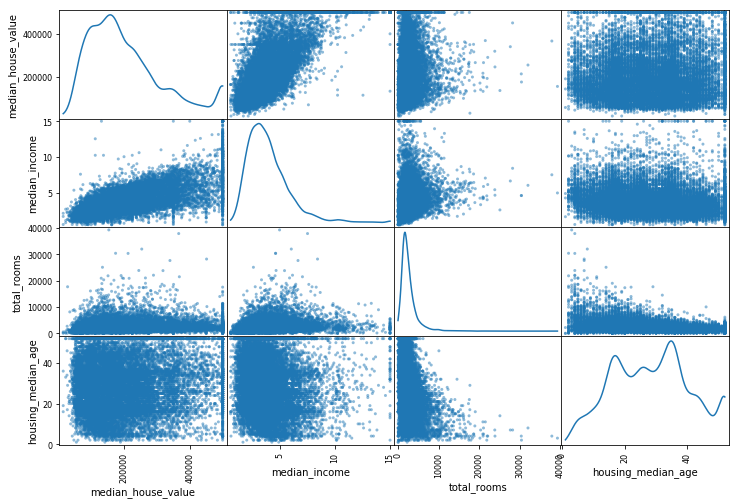

In [55]:
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='kde')

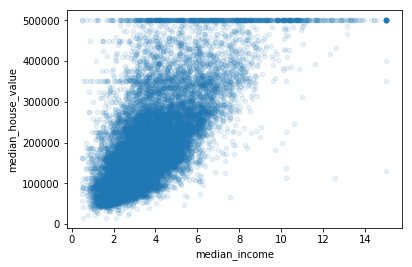

In [56]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [59]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [60]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [65]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

In [66]:
# Imputer は数値しか扱えないので ocean_proximity みたいな文字列データ、カテゴリデータは扱えない
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [68]:
imputer.statistics_, housing_num.median().values

(array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]),
 array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]))

In [69]:
X = imputer.transform(housing_num)

In [70]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [71]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [74]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded, housing_categories

(array([0, 0, 1, ..., 2, 0, 3]),
 Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object'))

In [75]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
# Copy from github.com/scikit-learn/scikit-learn/pull/9151
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.

    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot (aka one-of-K or dummy)
    encoding scheme (``encoding='onehot'``, the default) or converted
    to ordinal integers (``encoding='ordinal'``).

    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.

    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.

    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):

        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.

    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:

        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.

        The used categories can be found in the ``categories_`` attribute.

    dtype : number type, default np.float64
        Desired dtype of output.

    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros. In the inverse transform, an unknown category
        will be denoted as None.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.

    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).

    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.

    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
    array([[ 1.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.]])
    >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    array([['Male', 1],
           [None, 2]], dtype=object)

    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.

        Returns
        -------
        self

        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, str):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using specified encoding scheme.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.

        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.

        """
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, str):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        """Convert back the data to the original representation.

        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.

        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.

        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.

        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
                and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

In [96]:
cat_encoder = CategoricalEncoder(encoding='onehot-dense')
housing_cat_reshaped = housing_cat.values.reshape((-1, 1))
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [97]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [110]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [111]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense')),
])

In [153]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
], n_jobs=4)

In [154]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [114]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [117]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [120]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [121]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [124]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, y=housing_labels, scoring='neg_mean_squared_error', cv=10, n_jobs=4)
tree_rmse_scores = np.sqrt(-scores)

In [125]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [67523.584101   68282.47715369 69968.86339811 69873.54129356
 70909.08868622 74336.58658145 70714.3628707  70391.01120134
 75782.16225531 70661.70233348]
Mean: 70844.33798748697
Standard deviation: 2369.331027253191


In [126]:
lin_scores = cross_val_score(lin_reg, housing_prepared, y=housing_labels, scoring='neg_mean_squared_error', cv=10, n_jobs=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66761.08806582 66962.61740572 70349.95360142 74757.03175527
 68031.13388938 71193.84183426 64968.12170376 68261.9456752
 71527.63832548 67665.10082067]
Mean: 69047.84730769703
Standard deviation: 2735.504922908913


In [128]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing_prepared, y=housing_labels, scoring='neg_mean_squared_error', cv=10, n_jobs=4)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52523.35373622 49659.37924455 51400.94808038 54696.80967274
 53524.02696048 56356.83121246 51966.25753341 50450.7095786
 55020.68671519 53400.35250934]
Mean: 52899.93552433746
Standard deviation: 2001.9196268485564


In [131]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
%time grid_search.fit(housing_prepared, housing_labels)

CPU times: user 2.09 s, sys: 68 ms, total: 2.15 s
Wall time: 12.1 s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [132]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [133]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [134]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64464.85924896308 {'max_features': 2, 'n_estimators': 3}
55488.51090485093 {'max_features': 2, 'n_estimators': 10}
52754.57042403275 {'max_features': 2, 'n_estimators': 30}
60206.86585126729 {'max_features': 4, 'n_estimators': 3}
52709.79857701765 {'max_features': 4, 'n_estimators': 10}
50549.98797867778 {'max_features': 4, 'n_estimators': 30}
59274.91794556861 {'max_features': 6, 'n_estimators': 3}
52480.178418008356 {'max_features': 6, 'n_estimators': 10}
49999.275674597404 {'max_features': 6, 'n_estimators': 30}
58022.52785882755 {'max_features': 8, 'n_estimators': 3}
52076.39004274897 {'max_features': 8, 'n_estimators': 10}
49974.08080023704 {'max_features': 8, 'n_estimators': 30}
63369.752554774896 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54506.21170252188 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60320.32502990028 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53168.87898373669 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [161]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ['rroms_per_hhold', 'pop_per_hhold', 'bedrooms_per_rooms']
cat_pipeline = full_pipeline.transformer_list[1][1]
cat_encoder = cat_pipeline.named_steps['cat_encoder']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3578195865907473, 'median_income'),
 (0.15036549928854528, 'INLAND'),
 (0.11365870342004336, 'pop_per_hhold'),
 (0.08096056060254285, 'bedrooms_per_rooms'),
 (0.06967754268871035, 'longitude'),
 (0.06488779074405523, 'latitude'),
 (0.04673282611724569, 'rroms_per_hhold'),
 (0.042304676285876835, 'housing_median_age'),
 (0.015101543827428836, 'households'),
 (0.014948590846947383, 'total_rooms'),
 (0.014849041686031504, 'population'),
 (0.014783303825699125, 'total_bedrooms'),
 (0.009165428586414679, '<1H OCEAN'),
 (0.0027723874233209185, 'NEAR OCEAN'),
 (0.0018795343822902788, 'NEAR BAY'),
 (9.298368410039778e-05, 'ISLAND')]

In [162]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47954.22839070048

## Exercises

In [168]:
from sklearn.svm import SVR

svm_reg = SVR()
param_grid = [
    {'kernel': ['rbf', 'linear'], 'C': [0.5, 1.0]},
    {'kernel': ['poly'] ,'C': [0.5, 1.0], 'degree': [3, 5]},
]
grid_search = GridSearchCV(svm_reg, param_grid, scoring='neg_mean_squared_error', n_jobs=8, cv=5)
%time grid_search.fit(housing_prepared, housing_labels)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

CPU times: user 10.2 s, sys: 139 ms, total: 10.4 s
Wall time: 1min 56s
118775.4732239585 {'C': 0.5, 'kernel': 'rbf'}
115595.6067506938 {'C': 0.5, 'kernel': 'linear'}
118634.22435240951 {'C': 1.0, 'kernel': 'rbf'}
112571.79521013204 {'C': 1.0, 'kernel': 'linear'}
119092.53197751206 {'C': 0.5, 'degree': 3, 'kernel': 'poly'}
198461.34635431963 {'C': 0.5, 'degree': 5, 'kernel': 'poly'}
119008.20520939352 {'C': 1.0, 'degree': 3, 'kernel': 'poly'}
216706.3150644677 {'C': 1.0, 'degree': 5, 'kernel': 'poly'}


In [176]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distributions = {
    'kernel': ['rbf', 'linear'],
    'C': reciprocal(20, 2000),
    'gamma': expon(scale=1),
}
randomized_search = RandomizedSearchCV(svm_reg, param_distributions, cv=5,
                                      scoring='neg_mean_squared_error', n_jobs=8, verbose=2, n_iter=50, random_state=42)
randomized_search.fit(housing_prepared, housing_labels)

print("Score:", np.sqrt(-randomized_search.best_score_))
print("Param:", randomized_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=112.23032830669007, gamma=3.010121430917521, kernel=rbf .......
[CV] C=112.23032830669007, gamma=3.010121430917521, kernel=rbf .......
[CV] C=112.23032830669007, gamma=3.010121430917521, kernel=rbf .......
[CV] C=112.23032830669007, gamma=3.010121430917521, kernel=rbf .......
[CV] C=112.23032830669007, gamma=3.010121430917521, kernel=rbf .......
[CV] C=725.1235269152453, gamma=0.9084469696321253, kernel=linear ....
[CV] C=725.1235269152453, gamma=0.9084469696321253, kernel=linear ....
[CV] C=725.1235269152453, gamma=0.9084469696321253, kernel=linear ....
[CV]  C=725.1235269152453, gamma=0.9084469696321253, kernel=linear, total=  11.3s
[CV] C=725.1235269152453, gamma=0.9084469696321253, kernel=linear ....
[CV]  C=725.1235269152453, gamma=0.9084469696321253, kernel=linear, total=  11.4s
[CV] C=725.1235269152453, gamma=0.9084469696321253, kernel=linear ....
[CV]  C=725.1235269152453, gamma=0.9084469696321253, kernel=line

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.2min


[CV]  C=1507.0769018591086, gamma=0.0007790692366582295, kernel=linear, total=  13.2s
[CV] C=46.54135416767559, gamma=0.3627537294604771, kernel=linear ....
[CV]  C=1507.0769018591086, gamma=0.0007790692366582295, kernel=linear, total=  13.1s
[CV] C=46.54135416767559, gamma=0.3627537294604771, kernel=linear ....
[CV]  C=1507.0769018591086, gamma=0.0007790692366582295, kernel=linear, total=  12.9s
[CV] C=20.661536086480808, gamma=0.023332523598323388, kernel=rbf ....
[CV]  C=1507.0769018591086, gamma=0.0007790692366582295, kernel=linear, total=  13.2s
[CV] C=20.661536086480808, gamma=0.023332523598323388, kernel=rbf ....
[CV]  C=1507.0769018591086, gamma=0.0007790692366582295, kernel=linear, total=  14.0s
[CV] C=20.661536086480808, gamma=0.023332523598323388, kernel=rbf ....
[CV]  C=46.54135416767559, gamma=0.3627537294604771, kernel=linear, total=  13.1s
[CV] C=20.661536086480808, gamma=0.023332523598323388, kernel=rbf ....
[CV]  C=46.54135416767559, gamma=0.3627537294604771, kernel=li

[CV]  C=57.918545494176755, gamma=0.2757870542258224, kernel=linear, total=  11.3s
[CV] C=44.438490950798304, gamma=0.4960365360493639, kernel=linear ...
[CV]  C=44.438490950798304, gamma=0.4960365360493639, kernel=linear, total=  10.9s
[CV] C=44.438490950798304, gamma=0.4960365360493639, kernel=linear ...
[CV]  C=35.083786974901585, gamma=0.6835472281341501, kernel=rbf, total=  17.6s
[CV] C=44.438490950798304, gamma=0.4960365360493639, kernel=linear ...
[CV]  C=35.083786974901585, gamma=0.6835472281341501, kernel=rbf, total=  17.2s
[CV] C=422.7411888129144, gamma=0.37354658165762367, kernel=linear ...
[CV]  C=35.083786974901585, gamma=0.6835472281341501, kernel=rbf, total=  17.2s
[CV] C=422.7411888129144, gamma=0.37354658165762367, kernel=linear ...
[CV]  C=35.083786974901585, gamma=0.6835472281341501, kernel=rbf, total=  17.8s
[CV] C=422.7411888129144, gamma=0.37354658165762367, kernel=linear ...
[CV]  C=44.438490950798304, gamma=0.4960365360493639, kernel=linear, total=  10.4s
[CV] 

[CV] C=700.6796982317372, gamma=0.22153944050588595, kernel=linear ...
[CV]  C=243.4569416224485, gamma=0.15189814782062885, kernel=rbf, total=  16.9s
[CV] C=700.6796982317372, gamma=0.22153944050588595, kernel=linear ...
[CV]  C=42.8118380396981, gamma=0.01575994483585621, kernel=rbf, total=  17.7s
[CV] C=700.6796982317372, gamma=0.22153944050588595, kernel=linear ...
[CV]  C=42.8118380396981, gamma=0.01575994483585621, kernel=rbf, total=  17.1s
[CV] C=700.6796982317372, gamma=0.22153944050588595, kernel=linear ...
[CV]  C=42.8118380396981, gamma=0.01575994483585621, kernel=rbf, total=  17.1s
[CV] C=21.339765420739415, gamma=0.22169760231351215, kernel=linear ..
[CV]  C=700.6796982317372, gamma=0.22153944050588595, kernel=linear, total=  11.1s
[CV] C=21.339765420739415, gamma=0.22169760231351215, kernel=linear ..
[CV]  C=700.6796982317372, gamma=0.22153944050588595, kernel=linear, total=  11.2s
[CV] C=21.339765420739415, gamma=0.22169760231351215, kernel=linear ..
[CV]  C=700.67969823

[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  6.5min


[CV]  C=21.339765420739415, gamma=0.22169760231351215, kernel=linear, total=  11.4s
[CV] C=574.1750696390933, gamma=1.4752145260435134, kernel=rbf .......
[CV]  C=21.339765420739415, gamma=0.22169760231351215, kernel=linear, total=  13.0s
[CV] C=1424.3993036603229, gamma=1.052904084582266, kernel=linear ....
[CV]  C=21.339765420739415, gamma=0.22169760231351215, kernel=linear, total=  11.4s
[CV] C=1424.3993036603229, gamma=1.052904084582266, kernel=linear ....
[CV]  C=21.339765420739415, gamma=0.22169760231351215, kernel=linear, total=  11.7s
[CV] C=1424.3993036603229, gamma=1.052904084582266, kernel=linear ....
[CV]  C=1424.3993036603229, gamma=1.052904084582266, kernel=linear, total=  12.1s
[CV] C=1424.3993036603229, gamma=1.052904084582266, kernel=linear ....
[CV]  C=1424.3993036603229, gamma=1.052904084582266, kernel=linear, total=  11.3s
[CV] C=1424.3993036603229, gamma=1.052904084582266, kernel=linear ....
[CV]  C=574.1750696390933, gamma=1.4752145260435134, kernel=rbf, total=  1

[CV]  C=23.114705632539728, gamma=1.0117295509275495, kernel=linear, total=  12.6s
[CV] C=267.6585615312522, gamma=1.1891370222133257, kernel=rbf .......
[CV]  C=23.114705632539728, gamma=1.0117295509275495, kernel=linear, total=  12.1s
[CV] C=267.6585615312522, gamma=1.1891370222133257, kernel=rbf .......
[CV]  C=23.114705632539728, gamma=1.0117295509275495, kernel=linear, total=  12.0s
[CV] C=63.03974590387775, gamma=0.5282819748826726, kernel=rbf .......
[CV]  C=33.328183002476365, gamma=0.578634378499143, kernel=rbf, total=  16.8s
[CV] C=63.03974590387775, gamma=0.5282819748826726, kernel=rbf .......
[CV]  C=33.328183002476365, gamma=0.578634378499143, kernel=rbf, total=  16.6s
[CV] C=63.03974590387775, gamma=0.5282819748826726, kernel=rbf .......
[CV]  C=267.6585615312522, gamma=1.1891370222133257, kernel=rbf, total=  16.5s
[CV] C=63.03974590387775, gamma=0.5282819748826726, kernel=rbf .......
[CV]  C=267.6585615312522, gamma=1.1891370222133257, kernel=rbf, total=  18.8s
[CV] C=63

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed: 11.2min finished


Score: 69161.10169757146
Param: {'C': 1395.6562530252063, 'gamma': 0.09265545895311562, 'kernel': 'rbf'}


In [180]:
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    
    def fit(self, X, y=None):
        self.feature_indices_ = np.sort(np.argpartition(np.array(self.feature_importances), self.k)[-self.k:])
        return self

    def transform(self, X, y=None):
        return X[:, self.feature_indices_]

In [183]:
s = TopFeatureSelector(feature_importances, 5)
s.fit(None)
np.array(attributes)[s.feature_indices_]

array(['longitude', 'median_income', 'pop_per_hhold',
       'bedrooms_per_rooms', 'INLAND'], dtype='<U18')

In [184]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, 5)),
])

In [186]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, 5)),
    ('svm_reg', SVR(**randomized_search.best_params_))
])

In [187]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=4,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('... gamma=0.09265545895311562, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [190]:
predictions = prepare_select_and_predict_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(rmse)

70903.44421943417


In [195]:
param_grid = {
    'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances))),
}
grid_search = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                          n_jobs=8, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing, housing_labels)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median, total=   8.6s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=   8.8s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median, total=   9.0s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=   8.8s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=   9.3s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=   9.5s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median, total=   9.7s
[CV] feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=mean, total=   9.6s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median, total=   9.0s
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=median, total=   8.7s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent, total=   9.2s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent, total=   9.4s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent, total=  10.2s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent, total=   9.7s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num_pipeline__imputer__strategy=most_frequent, total=  10.0s


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean, total=  16.8s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean, total=  14.7s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean, total=  15.2s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean, total=  14.8s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=mean, total=  16.4s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median, total=  15.7s
[CV] feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median, total=  14.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=median, total=  13.9s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.1min


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.0s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.0s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.6s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  14.0s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.5s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=2, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.1s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  13.5s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  13.6s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  13.1s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=mean, total=  13.4s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  13.1s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  13.3s
[CV] feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  13.1s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  13.6s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=median, total=  12.9s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent, total=  13.7s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.1s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent, total=  13.9s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.1s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean, total=  13.3s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean, total=  13.6s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=3, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.5s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean, total=  13.3s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean, total=  13.2s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median, total=  13.4s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median, total=  13.9s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=mean, total=  13.9s
[CV] feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median, total=  13.4s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median, total=  13.9s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=median, total=  14.0s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.3s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.5s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.5s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.8s


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  14.4s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=4, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.7s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  14.0s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  14.1s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  13.6s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=mean, total=  13.7s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  13.3s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  14.0s
[CV] feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  13.8s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean 
[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  14.2s


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=median, total=  13.6s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.3s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.5s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.4s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.9s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=5, preparation__num_pipeline__imputer__strategy=most_frequent, total=  14.3s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  13.8s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  13.8s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  14.2s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  14.6s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=mean, total=  13.6s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  14.8s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  15.0s
[CV] feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  15.0s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  15.2s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=median, total=  15.4s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.9s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.3s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.0s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent, total=  17.2s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  14.8s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=6, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.1s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  15.9s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  15.6s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=mean, total=  15.7s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median, total=  15.9s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median, total=  15.5s
[CV] feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median, total=  15.3s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=median, total=  16.1s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent, total=  17.2s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.1s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.9s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent, total=  17.1s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=7, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.0s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean, total=  15.7s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean, total=  15.3s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean, total=  15.4s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median, total=  14.9s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV] feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median, total=  15.1s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median, total=  14.2s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.6s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.5s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.3s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.0s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=8, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.3s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  15.3s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  15.4s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  15.6s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=mean, total=  15.5s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  16.0s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  16.0s
[CV] feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  15.0s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  15.4s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=median, total=  16.8s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent, total=  17.2s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.9s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent, total=  17.4s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent, total=  18.2s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=9, preparation__num_pipeline__imputer__strategy=most_frequent, total=  17.4s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean, total=  14.9s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean, total=  14.7s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean, total=  15.2s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean, total=  15.2s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=mean, total=  14.7s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median, total=  14.2s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median, total=  14.4s
[CV] feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median, total=  14.1s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median, total=  14.2s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=median, total=  14.3s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.1s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  6.6min


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.2s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.1s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.0s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=10, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.4s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total=  14.5s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total=  14.5s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total=  14.4s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total=  14.5s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=mean, total=  14.6s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  14.6s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  14.7s
[CV] feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  14.7s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  14.9s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=median, total=  14.8s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.3s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.6s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.5s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.5s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=11, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.5s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean, total=  15.1s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean, total=  14.8s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean, total=  15.0s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=mean, total=  14.9s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median, total=  14.9s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median, total=  15.0s
[CV] feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median, total=  15.1s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median, total=  14.8s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=median, total=  14.9s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.2s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.7s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.7s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.0s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=12, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.8s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean, total=  15.5s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean, total=  15.1s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean, total=  15.1s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean, total=  15.1s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=mean, total=  15.4s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median, total=  15.1s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median, total=  15.1s
[CV] feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median, total=  15.2s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median, total=  15.2s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=median, total=  15.5s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.9s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.7s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.4s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.9s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean, total=  15.5s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=13, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.9s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean, total=  15.5s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean, total=  15.4s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean, total=  15.3s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=mean, total=  15.5s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total=  15.5s
[CV] feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total=  15.2s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total=  15.9s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=median, total=  15.4s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.2s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.1s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.1s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.1s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=14, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.2s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean, total=  15.9s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean, total=  15.8s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean, total=  15.6s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean, total=  15.4s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=mean, total=  15.7s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median, total=  15.5s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/naomichi/.

[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median, total=  16.0s
[CV] feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent 


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median, total=  15.8s


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=median, total=  15.6s
[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.5s
[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.5s
[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent, total=  16.3s
[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent, total=  15.2s


/home/naomichi/.local/share/virtualenvs/ml-python-docker-MJA_bkKk/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  feature_selection__k=15, preparation__num_pipeline__imputer__strategy=most_frequent, total=  12.4s


[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed: 10.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', FeatureUnion(n_jobs=4,
       transformer_list=[('num_pipeline', Pipeline(memory=None,
     steps=[('selector', DataFrameSelector(attribute_names=['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])), ('... gamma=0.09265545895311562, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [197]:
print(grid_search.best_score_)
print(np.sqrt(-grid_search.best_score_))
print(grid_search.best_params_)

-4779956205.816142
69137.22735123345
{'feature_selection__k': 14, 'preparation__num_pipeline__imputer__strategy': 'most_frequent'}
